In [1]:
#### Load the libraries 

import os
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", None, "display.max_columns", None)

# Data prep

## Oxford Economics data

File downloaded from Oxford Economics on 17th of June 2021
Last data Update date is 30th of April 2021

#### Load the file with GVA and Employment

In [2]:
# overall Greater London file
df = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Greater London GVA and Employment - 17 June 2021 10_48_24.xlsx', 'Default')

# Westminster file
westm = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Westminster GVA and Employment - 30 June 2021 15_29_52.xlsx', 'Default')
del westm['Databank']

In [3]:
df = df.append(westm, ignore_index=True)

#### Look at the data

In [4]:
#df.head()
#westm.head()

In [5]:
#df.dtypes

In [6]:
#list(df)

#### Reshape data

In [7]:
## Reshape 1: Turn years columns into one

df = pd.melt(df, id_vars=('Location',
 'Indicator',
 'Sector',
 'Units',
 'Scale',
 'Measurement',
 'Source',
 'Seasonally adjusted',
 'Base year price',
 'Base year index',
 'Historical end',
 'Date of last update',
 'Source details',
 'Additional source details',
 'Contact email',
 'Location code',
 'Indicator code')
  , var_name="year", value_name="value" )

In [8]:
#df

In [9]:
## Reshape 2: Make sectors as columns
## a lot of columns will have to go so that reshape is efficient
# reset index gets rid of the multilevel structure

df = pd.pivot_table(df, values='value', index=['Location',
 'Indicator',
 'Units',
 'Scale',
 'Measurement',
 'year'],
columns=['Sector']).reset_index()

In [10]:
#df

In [11]:
#list(df)

In [12]:
df["Aggr2"] = df['Real estate activities'] + df['Financial and insurance'] +  df['Professional, scientific and tech'] + df['Information and communication'] + df['Administrative and support']
df["Aggr3"] = df["Aggr2"] + df['Public administration and defence']  + df['Education']   
df["Aggr1"] = df["Aggr2"] - df['Information and communication'] 

In [13]:
#list(df)

In [14]:
df_aggr = df.iloc[:, [0,1,2,3,4,5, 10, 11, 15, 16, 17]]

In [15]:
#df_aggr

In [16]:
# looks like 'Office aggregate (incl. ICT)' is the same as Aggr2 
# and 'Office aggregate (excl. ICT)' is the same as Aggr1
# re-create df_aggr w/t these columns
df_aggr = df.iloc[:, [0,1,2,3,4,5, 15, 16, 17]]

In [17]:
#df_aggr
## Aggr 1 - excluding ICT
## Aggr 2 - including ICT
## Aggr 3 - including Public admistration and defence & Education

In [18]:
#list(df_aggr)

In [19]:
## Reshape 3: Turn Aggr columns into one
df_aggr = pd.melt(df_aggr, id_vars=('Location',
 'Indicator',
 'Units',
 'Scale',
 'Measurement',
 'year')
  , var_name="Aggr_version", value_name="value" )

In [20]:
# create future column names

df_aggr["Aggr_version"]  = df_aggr['Aggr_version'].str[-1:]
df_aggr["Indic_group"] = np.where(df_aggr['Indicator'] == "GVA by Sector", "GVA"+ df_aggr["Aggr_version"], "Employment"+ df_aggr["Aggr_version"]) 

In [21]:
#df_aggr

In [22]:
# Final Reshape
## Reshape 4: Turn Aggregate Indicators into columns

df_aggr = df_aggr.pivot_table( values='value', 
index=['year', 'Location'],
columns=['Indic_group']).reset_index()

In [23]:
df_aggr['year'] = df_aggr['year'].astype(int)

In [24]:
# Separate the two files

# Westmin
oxecon_westmin = df_aggr[df_aggr['Location']=='Westminster']
del oxecon_westmin['Location']
oxecon_westmin['Submarket'] ='West End'

# Overall Greater London
df_aggr = df_aggr[df_aggr['Location']=='Greater London']
del df_aggr['Location']

<ipython-input-24-6266e72cc04c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxecon_westmin['Submarket'] ='West End'


In [25]:
# rename columns for the Westminster to have them as additional columns in the final files
for i in ['Employment1', 'Employment2', 'Employment3', 'GVA1', 'GVA2', 'GVA3']:
    oxecon_westmin=oxecon_westmin.rename(columns = {i:i+'_westmin'})

#### Load the GDP Deflator file

In [26]:
defl = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\GDP deflator - 21 June 2021 11_11_10.xlsx', 'Default')

c:\users\sleptcom\appdata\local\programs\python\python39\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [27]:
# only keep relevant columns and rows
defl = defl[['Year','Level values']]
defl = defl[defl['Level values'] != "Level values"]

In [28]:
# rename columns
defl=defl.rename(columns = {'Level values':'GDP deflator', 'Year':'year'})

In [29]:
#defl

## PMA data

File obtained from PMA on 7th of June 2021. The data we are using is Prime rent and Stock series

#### Load the data on Prime Rents, Stock, Availability and Vacancy

In [30]:
rent = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls', 'PRIME RENTS - GBP PSF PA', skiprows = 9)

In [31]:
stock = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls', 'STOCK', skiprows = 9)

In [32]:
vacancy = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls', 'VACANCY', skiprows = 9)

In [33]:
avail = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls', 'AVAILABILITY', skiprows = 9)

#### Look at the data

In [34]:
avail.head()

,Market: Submarket,Country,Description,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,London: City,United Kingdom,"Availability (000s, sqft)",1461.75,2191.506,3195.505,4057.246,3535.85,2487.411,1189.666,2235.551,4253.575,7665.654,9577.085,10989.061,9818.315,6613.002,5969.014,5245.464,5738.921,4307.412,3433.065,4897.105,1489.568,4592.898,8645.434,10981.188,9434.060,6720.093,5116.452,6401.153,7935.537,8004.742,6837.285,7113.264,7144.351,6360.852,4029.591,4071.412,5376.152,5624.173,5283.393,5289.034,7152.989
1,London: West End,United Kingdom,"Availability (000s, sqft)",NaN,NaN,NaN,NaN,2570.00,2500.000,2110.000,1720.000,1650.000,2090.000,4362.869,6965.695,7747.141,6752.385,5724.892,4855.684,4430.267,2768.908,2839.993,2465.959,1578.875,4161.613,4663.511,5730.124,5194.651,3888.498,2866.620,2233.272,4358.400,4384.007,3924.110,3440.773,3612.603,3589.982,2944.852,2268.811,4170.819,3677.056,3725.455,2481.108,4136.457


In [35]:
#Append all the data together
pma = rent.append(stock, ignore_index=True)
pma = pma.append(vacancy, ignore_index=True)
pma = pma.append(avail, ignore_index=True)

In [36]:
#list(pma)
#pma

#### Reshape data

In [37]:
# Reshape 1: Turn years into 1 column
pma = pd.melt(pma, id_vars=('Market: Submarket','Country', 'Description',)
  , var_name="year", value_name="value" )

In [38]:
# Remove London from the submarket name
pma['Market: Submarket'] = pma['Market: Submarket'].str.split(': ').str[1]

# rename Submarket column
pma=pma.rename(columns = {'Market: Submarket':'Submarket'})

In [39]:
# Reshape 2: Turn Prime rent and Stock into columns

pma = pma.pivot_table(values='value', index=['year', 'Submarket'], columns=['Description']).reset_index()

In [40]:
# rename columns
pma=pma.rename(columns = {'Prime Rents (GBP, psf, pa)':'prime_rent', 'Stock (000s, sqft)':'stock', 'Vacancy (% of stock)':'vacancy', 'Availability (000s, sqft)':'availability' })

In [41]:
pma = pma.sort_values(by=['Submarket', 'year'])

## KF data

KF data we use is developemnt pipeline data - to forecast the stock

#### Load the data on Dev Pipeline

In [42]:
dev_pipe = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\London Development Pipeline Review and Viability Index - Landsec Additions.xlsx', 'London Dev. Pipeline', skiprows = [0,2,3])

c:\users\sleptcom\appdata\local\programs\python\python39\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [43]:
#dev_pipe

#### Slicing and aggregating the data

Slicing and aggregating the data to get the total pipeline values for City and West End submarkets

In [44]:
# drop the first empty column
dev_pipe = dev_pipe.drop('Unnamed: 0', 1)

In [45]:
list(dev_pipe)

['Address',
 'Developer / Equity',
 'Area',
 'Submarket',
 'Grade',
 'Total Development Size',
 'Pre-Let Size',
 'Under Offer Size',
 'Available \nSize',
 'Available + Under Offer Size',
 'Scheme Stage',
 'Spec or Pre-Let Intention',
 'Earliest Possible PC Date',
 'Earliest Possible PC Year',
 'Planning',
 'Finance',
 '3rd Party Rights',
 'VP',
 'Construction',
 'Overall',
 'Viability\nProbability',
 'KF Instruction',
 'KF Lead Contact',
 'Sq Ft Error Check',
 'Score Error Check']

In [46]:
# filter data - only keep records with high certainty (Overall 9 and 10)
# only keep records that will complete from 2021 onwards
dev_pipe = dev_pipe[(dev_pipe["Overall"]==9) | (dev_pipe["Overall"]==10)]
dev_pipe = dev_pipe[dev_pipe["Earliest Possible PC Year"]>2020]

In [47]:
# Select the records that are City in PMA definition - EC1, EC2, EC3, EC4 postcodes
dev_pipe["New_subm"] = np.where(dev_pipe['Address'].str.contains("EC1|EC2|EC3|EC4"),"City",dev_pipe["Submarket"]) 

In [48]:
# creating West End from West End Core, Fitzrovia, Soho, Victoria and Marylebone
dev_pipe["New_subm"] = np.where( ((dev_pipe['New_subm'] == "Victoria") | (dev_pipe['New_subm'] == "Soho") | (dev_pipe['New_subm'] == "Fitzrovia") | (dev_pipe['New_subm'] == "Marylebone") | (dev_pipe['New_subm'] == "West End Core")), "West End", dev_pipe["New_subm"] ) 

In [49]:
# only keep relevant columns
dev_pipe = dev_pipe[['New_subm','Total Development Size','Earliest Possible PC Year']]

In [50]:
# rename columns - Year and Submarket
dev_pipe=dev_pipe.rename(columns = {'Earliest Possible PC Year':'year', 'New_subm':'Submarket'})

In [51]:
# sum by submarket and year
dev_pipe = dev_pipe.groupby(['Submarket','year'])['Total Development Size'].sum().reset_index()

In [52]:
# keep only City and West End 
dev_pipe = dev_pipe[(dev_pipe['Submarket'] == "City") | (dev_pipe['Submarket'] == "West End") ]

In [53]:
dev_pipe

,Submarket,year,Total Development Size
11,City,2021.0,1838037
12,City,2022.0,2348062
13,City,2023.0,1894744
14,City,2024.0,424023
37,West End,2021.0,1235745
38,West End,2022.0,693233
39,West End,2023.0,444264
40,West End,2025.0,217000


## CoStar data

In [54]:
costar_city = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\CoStar Stock and Vacancy City - 22 June 2021.xlsx', 'DataExport')
costar_westend = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\CoStar Stock and Vacancy West End - 22 June 2021.xlsx', 'DataExport')

In [55]:
costar_city['Submarket'] = 'City'
costar_westend['Submarket'] = 'West End'

In [56]:
# append the datasets
costar = costar_city.append(costar_westend, ignore_index=True)
costar['year'] = costar['Period'].str[0:4].astype(int)
costar['stock_growth'] = costar.groupby(['Submarket'])['Inventory SF'].pct_change()
costar = costar[['year', 'Submarket' ,'stock_growth', 'Vacancy Rate', 'Inventory SF']]
costar=costar.rename(columns = {'Inventory SF':'stock_costar'})

In [57]:
#costar_westend

## Merging the datasets

In [58]:
# merge PMA Rent and Stock Data and GDP deflator
pma_and_defl  = pd.merge(pma, defl, on='year', how = 'right') # this will create empty rows

In [59]:
pma_and_defl["Submarket"] = np.where(pma_and_defl['year']>2020,"City",pma_and_defl["Submarket"])  # replace existing empty rows with City

In [60]:
# create duplicate rows and replace for West End
dupl = pma_and_defl.iloc[82:88].copy()
dupl.columns = pma_and_defl.columns
dupl["Submarket"] = "West End"
#print(dupl)

In [61]:
# append to the original
pma_and_defl = pma_and_defl.append(dupl, ignore_index=True)
#pma_and_defl

In [62]:
# add OE data on Employment and GVA
pma_and_defl_and_OE =  pd.merge(pma_and_defl, df_aggr, on='year')

In [63]:
# add Dev Pipeline
pma_and_defl_and_OE_and_devpipe =  pd.merge(pma_and_defl_and_OE, dev_pipe, on=['year', 'Submarket'], how = 'left')

In [64]:
# Add Wesyminster columns
pma_and_defl_and_OE_and_devpipe = pd.merge(pma_and_defl_and_OE_and_devpipe, oxecon_westmin, on=['year', 'Submarket'], how = 'left')
pma_and_defl_and_OE_and_devpipe

,year,Submarket,availability,prime_rent,stock,vacancy,GDP deflator,Employment1,Employment2,Employment3,GVA1,GVA2,GVA3,Total Development Size,Employment1_westmin,Employment2_westmin,Employment3_westmin,GVA1_westmin,GVA2_westmin,GVA3_westmin
0,1980.0,City,1461.750,23.06,42481.407,3.440917,27.80414,804.8280,1033.1270,1640.2770,46427.63,57322.63,103506.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980.0,West End,NaN,20.00,50169.255,3.500000,27.80414,804.8280,1033.1270,1640.2770,46427.63,57322.63,103506.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981.0,City,2191.506,25.16,43750.482,5.009101,31.23171,796.7573,1018.3363,1607.0943,44491.60,55009.10,97539.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981.0,West End,NaN,23.10,50379.365,4.000000,31.23171,796.7573,1018.3363,1607.0943,44491.60,55009.10,97539.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1982.0,City,3195.505,27.26,45211.730,7.067867,33.73242,802.1086,1020.8456,1600.6086,43482.97,53313.40,92259.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1982.0,West End,NaN,25.00,50589.476,4.500000,33.73242,802.1086,1020.8456,1600.6086,43482.97,53313.40,92259.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1983.0,City,4057.246,31.45,46169.660,8.787689,35.60236,831.9567,1049.1757,1626.7017,44962.51,54827.45,92688.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1983.0,West End,NaN,25.00,50799.587,5.500000,35.60236,831.9567,1049.1757,1626.7017,44962.51,54827.45,92688.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1984.0,City,3535.850,32.50,46819.103,7.552152,37.46053,870.9718,1092.3988,1668.6758,47307.42,57515.32,94764.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1984.0,West End,2570.000,25.00,51385.692,5.001392,37.46053,870.9718,1092.3988,1668.6758,47307.42,57515.32,94764.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Creating forecast for stock

In [65]:
final =  pma_and_defl_and_OE_and_devpipe.copy()

In [66]:
# Add demolitions column based on PMA's advice - 1200 for West End and 1300 for City
final['Demolitions'] = 1200
final['Demolitions'] = np.where(final['Submarket'] =='City',1300,final['Demolitions']) 
final['Demolitions'] = np.where(final['year'] <2021 ,0,final['Demolitions'] ) 

In [67]:
# divide the Development number by 1000 so that all stock is in the same units
# replace NAs with zeros so that the summing works

final['Total Development Size'] = final['Total Development Size']/1000
final['Total Development Size'] = final['Total Development Size'].fillna(0)

In [68]:
final = final.sort_values(by=['Submarket', 'year'])

In [69]:
final['stock'] = final.groupby(['Submarket'])['stock'].fillna(method='ffill') #fill stock values forward
final['Cum_Demol'] = final.groupby(['Submarket'])['Demolitions'].cumsum() # create running total of Demolitions
final['Cum_Devel'] = final.groupby(['Submarket'])['Total Development Size'].cumsum() # create running total of Developments

In [70]:
# calculate future stock
final['stock'] = np.where(final['year'] >2020,final['stock']+final['Cum_Devel']-final['Cum_Demol'],final['stock'] ) 
#final

In [71]:
# add CoStar stock growth and vacancy
final =  pd.merge(final, costar, on=['year', 'Submarket'], how = 'left')

In [72]:
# create alternative stock using CoStar stock growth rate
final['stock2'] = np.where(final['year'] >2020,final['stock'].shift(1)*(1+final['stock_growth']),final['stock']) 

In [73]:
# keep only relevant columns

In [74]:
final = final.drop(['Cum_Devel', 'Cum_Demol', 'Demolitions','Total Development Size', 'stock_growth'], axis=1)
#final

## Transforming the variables

### Deflate the rents

In [75]:
# I want the real rents to be 2021 values, so I will first re-base the GDP deflator to 2021
print(final[final['year']==2021].index.values)
final.iloc[41,6]

# rebase
final['GDP deflator'] = final['GDP deflator']/final.iloc[41,6]*100

[41 88]


105.3813

In [76]:
# Deflate the nominal rent 
final['real_rent'] = (final['prime_rent']/final['GDP deflator']*100).astype(float)

In [77]:
#final.dtypes

### Log the vars

In [78]:
# take logarithms of vars
logged_vars = np.log(final[['stock','stock2','stock_costar','prime_rent','real_rent','availability','vacancy','Employment1','Employment2','Employment3', 'GVA1', 'GVA2', 'GVA3','Employment1_westmin','Employment2_westmin','Employment3_westmin', 'GVA1_westmin', 'GVA2_westmin', 'GVA3_westmin']])
#add prefix to var names
logged_vars = logged_vars.add_prefix('ln_')

In [79]:
# add logged vars back to the dataset
final = pd.concat([final, logged_vars], axis=1)

### Split into City/West End

In [80]:
# split into City and West End
city = final[final['Submarket']=='City']
city = city.loc[:,~city.columns.str.contains('westmin', case=False)]  # remove _westmin columns from a City dataset

westend = final[final['Submarket']=='West End']

In [81]:
#city

### Split into historical and forecast

In [82]:
# forecast
city_forecast = city[city['year']>2020]
westend_forecast = westend[westend['year']>2020]

# historical
city_history = city[city['year']<=2020]
westend_history = westend[westend['year']<=2020]

# Error Correction Model

final is the result of the Data Prep

For the three Employment and GVA options:

Aggr 1 - excluding ICT;
Aggr 2 - including ICT;
Aggr 3 - including Public admistration and defence & Education

For the two Stock options:

Stock - PMA stock , with forecast values created based on KF dev pipeline and average demolitions;

Stock2 - PMA stock, with forecast values created using similar CoStar submarket stock growth

In [83]:
from statsmodels.tsa import stattools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

### City

#### Testing variables for the presence of unit root

<AxesSubplot:title={'center':'Real rent - City'}, xlabel='year'>

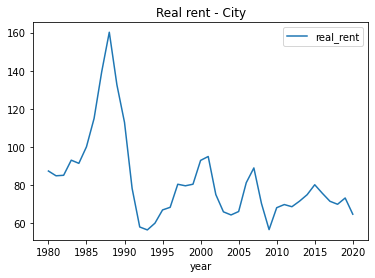

In [84]:
# Plot the series to understand how to best specify the ADF test (time trend or no time trend)
city_history.plot(x='year', y='real_rent', title = 'Real rent - City')

In [85]:
#city

In [86]:
# copied and modified the function for ADF test from the official documentation
# added the regression specification and the line on actual decision
# depending on the above plot, comment out or keep the line with "regression"

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC'
                      #, regression='ct'
                     )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print ('We cannot reject (the null) that there is a unit root, the series are non-stationary' if dfoutput['p-value']>0.05 else 'The null (there is a unit root) is rejected, no unit root, the series is stationary')

In [87]:
# apply adf test function to the series of choice. The null is that there IS a unit root
# 0:41 is to specify hist values
adf_test(city_history['real_rent'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.026106
p-value                         0.032527
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
The null (there is a unit root) is rejected, no unit root, the series is stationary


#### Long-run model

<AxesSubplot:label='36f44c5e-fd94-4fbc-99ef-c5bf0ca180b7'>

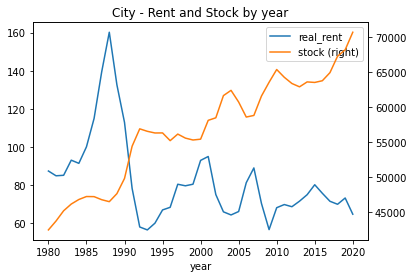

In [88]:
# Plot double axis plots to see the relationship between vars 
# this one is for City

rent_plot = city_history.plot(x='year', y='real_rent')
city_history.plot(x='year', y='stock',secondary_y=True, ax=rent_plot, title = 'City - Rent and Stock by year')

In [89]:
# Long run City

# Although Employment1 has the highest Adj R2, the residual is non-stationary
long_run_city = sm.OLS.from_formula(formula='ln_real_rent ~ ln_stock +ln_Employment2',data = city_history).fit()
print(long_run_city.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_real_rent   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     54.38
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           7.08e-12
Time:                        12:53:06   Log-Likelihood:                 28.928
No. Observations:                  41   AIC:                            -51.86
Df Residuals:                      38   BIC:                            -46.71
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         32.2525      2.788     11.

<ipython-input-90-bdacbf0e051e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_history['resid'] = long_run_city.resid
<ipython-input-90-bdacbf0e051e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_history['resid_lag'] = city_history['resid'].shift(1)
<ipython-input-90-bdacbf0e051e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

<AxesSubplot:title={'center':'City - Rent and Equilibrium (fitted) rent by year'}, xlabel='year'>

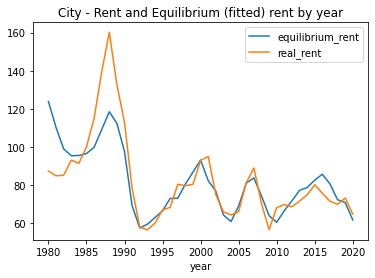

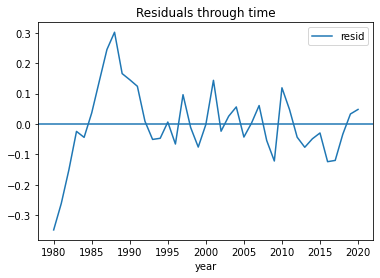

In [90]:
# get residuals, lagged residuals and fitted values and create plots

city_history['resid'] = long_run_city.resid
city_history['resid_lag'] = city_history['resid'].shift(1)

city_history['equilibrium_rent'] = np.exp(long_run_city.fittedvalues)

equil_rent = city_history.plot(x='year', y='equilibrium_rent')
city_history.plot(x='year', y='real_rent', ax=equil_rent, title = 'City - Rent and Equilibrium (fitted) rent by year')

resid_plot = city_history.plot(x='year', y='resid', title = 'Residuals through time')
resid_plot.axhline(y=0)

In [91]:
# test the stationarity of resid - City
# residuals are stationary - the trend is removed

adf_test(long_run_city.resid)

Results of Dickey-Fuller Test:
Test Statistic                 -2.966361
p-value                         0.038158
#Lags Used                      2.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
The null (there is a unit root) is rejected, no unit root, the series is stationary


#### Short-run model

In [92]:
# create the first differences
for i in ['ln_real_rent', 'ln_stock', 'ln_Employment2']:
    city_history['diff_'+i] = city_history[i].diff()

<ipython-input-92-e1d0c65be4ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_history['diff_'+i] = city_history[i].diff()


In [93]:
# fitting the short-run model
# error term has an expected negative sign
# i.e. there is an adjustment towards a long-run equilibrium
short_run_city = sm.OLS.from_formula(formula='diff_ln_real_rent ~ diff_ln_stock + diff_ln_Employment2+resid_lag',data = city_history).fit()
print(short_run_city.summary())

                            OLS Regression Results                            
Dep. Variable:      diff_ln_real_rent   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     34.94
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           9.25e-11
Time:                        12:53:07   Log-Likelihood:                 50.443
No. Observations:                  40   AIC:                            -92.89
Df Residuals:                      36   BIC:                            -86.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0441    

#### Creating the forecast

In [95]:
# Predict log of equilibrium rent, ln_real_rent_hat, outside of loop, as this value doesn't change
# because it only depends on logs of employment and stock
city['ln_real_rent_hat'] = long_run_city.predict(city[['ln_stock', 'ln_Employment2']])
# let's also create equilibrium rent (the above , but not logged)
city['equilibrium_rent'] = np.exp(city['ln_real_rent_hat'])

# create the first differences of ln stock and ln employment, these also don't change
for k in ['ln_stock', 'ln_Employment2']:
    city['diff_'+k] = city[k].diff()
    
# a loop to create ln_real_rent prediction
for i in range(41, 46):
    # Step 1: calculate error and create error lags
    city['resid'] = city['ln_real_rent'] - city['ln_real_rent_hat']
    city['resid_lag'] = city['resid'].shift(1)
    
    # Step 2: predict first differences in ln_real_rent by fitting the short-run model, now having one more error observation
    # resulting from previous step
    city['diff_ln_real_rent_hat'] = short_run_city.predict(city[['diff_ln_stock', 'diff_ln_Employment2', 'resid_lag']])
    
    # Step 3: use the new first difference observation to calculate ln_real_rent using 
    # lag of ln_real_rent
    city["ln_real_rent"] = np.where(city.index == i, city['diff_ln_real_rent_hat'] + city['ln_real_rent'].shift(1), city['ln_real_rent'])  

In [96]:
# after the loop, de-log the rent
city['real_rent_forecast'] = np.exp(city['ln_real_rent'])
# nominalise the rent, using GDP-delator forecast
city['prime_rent_forecast'] = (city['real_rent_forecast'] * city['GDP deflator']) / 100

In [ ]:
# plot the forecast

city.plot(x='year', y='prime_rent_forecast', title = 'Prime rent (nominal) - City')

In [97]:
city['equilibrium_rent']

0     123.841295
1     110.266955
2      99.047598
3      95.401578
4      95.552543
5      96.541091
6      99.845748
7     109.150827
8     118.510093
9     112.409557
10     97.637377
11     69.152071
12     57.531619
13     59.444225
14     62.930433
15     66.561377
16     73.016686
17     73.081183
18     80.566523
19     86.831412
20     93.144810
21     82.322222
22     76.862963
23     64.331122
24     60.850168
25     69.057380
26     81.039183
27     83.791462
28     74.305546
29     63.993498
30     60.511214
31     66.595231
32     71.724857
33     77.282174
34     78.718938
35     82.621067
36     85.714114
37     80.634157
38     72.343096
39     70.880866
40     61.722240
41     59.347048
42     58.298936
43     58.136215
44     61.434289
45     66.218844
46     71.315902
Name: equilibrium_rent, dtype: float64

In [ ]:
# calculate ln_rent_rent for the next period
#city["ln_real_rent"] = np.where(city['index'] == i, city['diff_ln_real_rent_hat'] + city['ln_real_rent'].shift(1), city['ln_real_rent']) 
#city["ln_real_rent"] = np.where(city.index == 41, city['diff_ln_real_rent_hat'] + city['ln_real_rent'].shift(1), city['ln_real_rent']) 
city

In [ ]:
# defines a function to perform rolling forecasts with a ECM and intakes a y_var as a string
# X_vars as a list, lr_X_vars as a list, and the rest of the inputs are dataframes, with lr_
# indicating level variables used to estimate the long-run relationship, and diff_ representing
# differenced data
def roll_forecast_ecm(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test):
    
    # creates two new dataframes that will be added to as the forecast rolls 
    history = lr_train
    diff_history = diff_train
    
    # estimates a linear model to predict the longrun relationship
    lr_model_train = sm.OLS(history[[y_var]], history[lr_X_vars])
    # fits the lr model
    lr_model_train_fit = lr_model_train.fit(cov_type='HC0')
    # adds a disequilibrium column for the training period
    diff_train['disequilibrium'] = lr_model_train_fit.resid.shift(1)
    
    
    # this chunk of data does one-step ahead predictions of the disequilibrium    
    
    # creates an empty list that will hold the residuals for the next period
    disequilibrium = []
    
    # loops through the indexes of the set being forecasted
    for i in range(len(lr_test)):
        
        # estimates a linear model to predict the longrun relationship
        lr_model = sm.OLS(history[[y_var]], history[lr_X_vars])
        # fits the lr model
        lr_model_fit = lr_model.fit(cov_type='HC0')
        # forecasts the disequilibrium in the next period and appends it to the list by predicting 
        # the closing price using the 1st lagged value of the independent variable at t+1, which makes it
        # at time t, and subtracting the closing price at time t, giving the residual for time t, which is 
        # t - 1 for the future value we want to predict
        disequilibrium_hat = (float(lr_model_fit.predict(history[-1:][lr_X_vars]))
                             - float(history[-1:].close.values))
        disequilibrium.append(disequilibrium_hat)
        # grabs the observation at the ith index
        obs = lr_test[i : i + 1]
        # appends the observation to the estimation data set
        history = history.append(obs)
        
    # creates a column of the lagged disequilibrium values
    diff_test['disequilibrium'] = disequilibrium
    
    
    # this chunk of code does the 1-step ahead ECM estimation and prediction
    
    predictions = []
    
    # this list will store the error_correction coefficients  
    error_correction_coefficients = []
    # this list stores the standard error of the EC coefficients
    error_correction_coef_stderr = []
    
    # loops through the indexes of the set being forecasted
    for i in range(len(diff_test)):
        
        # estimates an ECM to predict future values
        ecm_model = sm.OLS(diff_history[[y_var]], diff_history[X_vars])
        # fits the ECM
        ecm_model_fit = ecm_model.fit(cov_type='HC0')
        # predicts the future closing price change and appends it to the list of predictions
        delta_y_hat = float(ecm_model_fit.predict(diff_test[i : i + 1][X_vars]))
        predictions.append(delta_y_hat)
        # grabs the observation at the ith index
        obs = diff_test[i : i + 1]
        # appends the observation to the estimation data set
        diff_history = diff_history.append(obs)
        
        # appends the error_correction coefficient to the list  
        error_correction_coefficients.append(ecm_model_fit.params.disequilibrium)
        error_correction_coef_stderr.append(ecm_model_fit.HC0_se.disequilibrium)
    
    # adds columns for our lists
    diff_test['delta_y_hat'] = predictions     
    diff_test['ec_coef'] = error_correction_coefficients
    diff_test['ec_stderr'] = error_correction_coef_stderr
    
    # returns predictions
    return(diff_test, ecm_model_fit)  

### West End

In [ ]:
# Plot West End

rent_plot = westend.plot(x='year', y='real_rent')
westend.plot(x='year', y='availability',secondary_y=True, ax=rent_plot, title = 'West End - Rent and Availability by year')

#### Long-run model

In [ ]:
# Long run West End

# In a set up with Availability, when demand is proxied via Employment, the Availability is insignificant
# when demand is proxed via GVA, with GVA1 and GVA2 - significant at 5%, with GVA3 - at 10 %
# with GVA1 the Adj R2 is slightly larger - 0.823 vs 0.820 in the model with GVA2

# when stock is used as a supply variable, the sign is positive.

long_run_westend = sm.OLS.from_formula(formula='ln_real_rent ~ ln_availability +ln_GVA1',data = westend).fit()
print(long_run_westend.summary())

In [ ]:
# get residuals, lagged residuals and fitted values and create plots
westend['resid'] = long_run_westend.resid
westend['resid_lag'] = westend['resid'].shift(1)

westend['equilibrium_rent'] = np.exp(long_run_westend.fittedvalues)

equil_rent = westend.plot(x='year', y='equilibrium_rent')
westend.plot(x='year', y='real_rent', ax=equil_rent, title = 'West End - Rent and Equilibrium (fitted) rent by year')

resid_plot = westend.plot(x='year', y='resid', title = 'Residuals through time')
resid_plot.axhline(y=0)

In [ ]:
# Testing the stationarity of residual
# residual is stationary
adf_test(long_run_westend.resid)

In [ ]:
#westend.to_csv('G:\\29 Data Analytics\\Commercial research projects\\MS\\CL office rents\\westend.csv')